# library

In [47]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import os
import cv2
import copy
import PIL
from PIL import Image

import random

import os

# GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


# dataset

In [4]:
# as_supervised = True 추가
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split =['train', 'test'], 
    shuffle_files =True, 
    as_supervised = True,
    with_info = True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [6]:
tf.data.experimental.cardinality(ds_train)
tf.data.experimental.cardinality(ds_test)

<tf.Tensor: shape=(), dtype=int64, numpy=8580>

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [8]:
NUM_CLASSES = ds_info.features['label'].num_classes
print(NUM_CLASSES)

120


In [8]:
ds_info.features['label'].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

In [9]:
ds_info

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='/aiffel/tensorflow_datasets/stanford_dogs/0.2.0',
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
        'objects': Sequence({
            'bbox': BBoxFeature

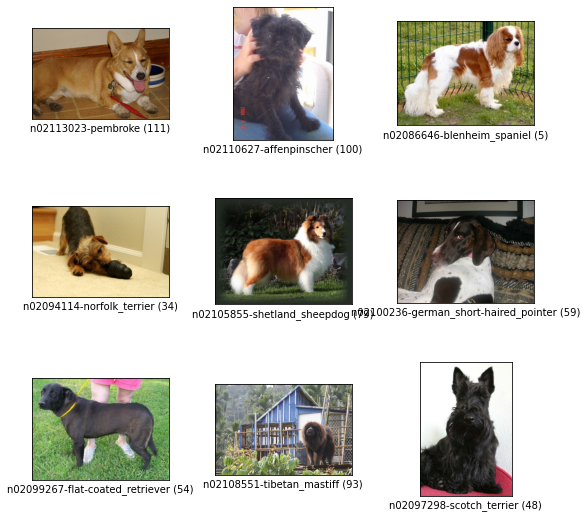

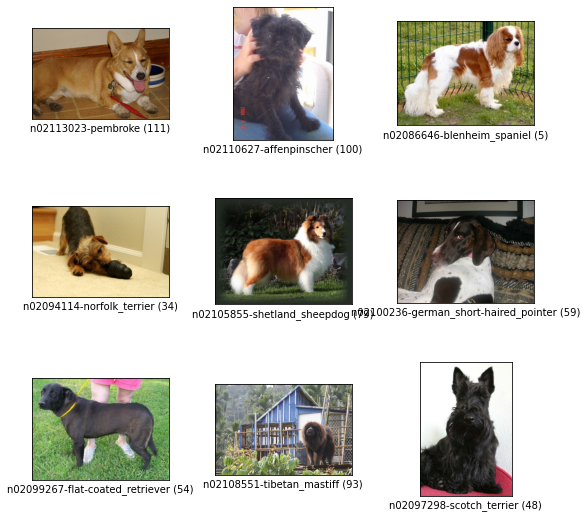

In [10]:
tfds.show_examples(ds_train, ds_info)

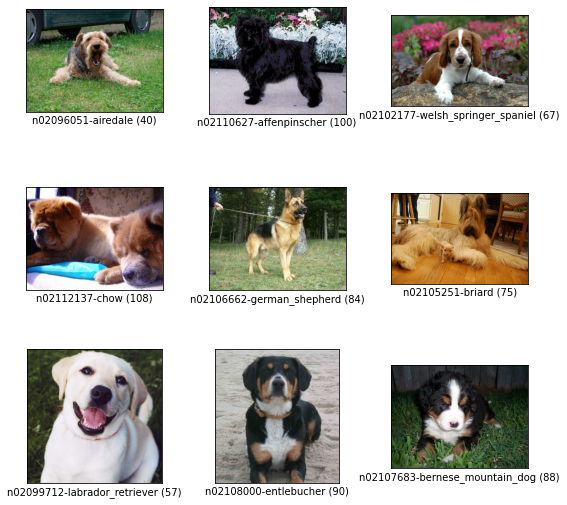

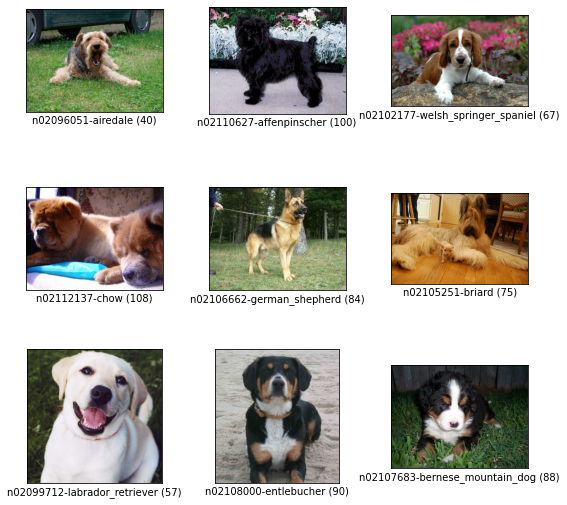

In [11]:
tfds.show_examples(ds_test,ds_info)

# image preprocessing

In [71]:
BATCH_SIZE = 16
EPOCHS = 10

In [72]:
# label 같이 들어와서 변경
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [73]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=BATCH_SIZE):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

In [13]:
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


# CAM

In [51]:
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(NUM_CLASSES, activation ='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [52]:
cam_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

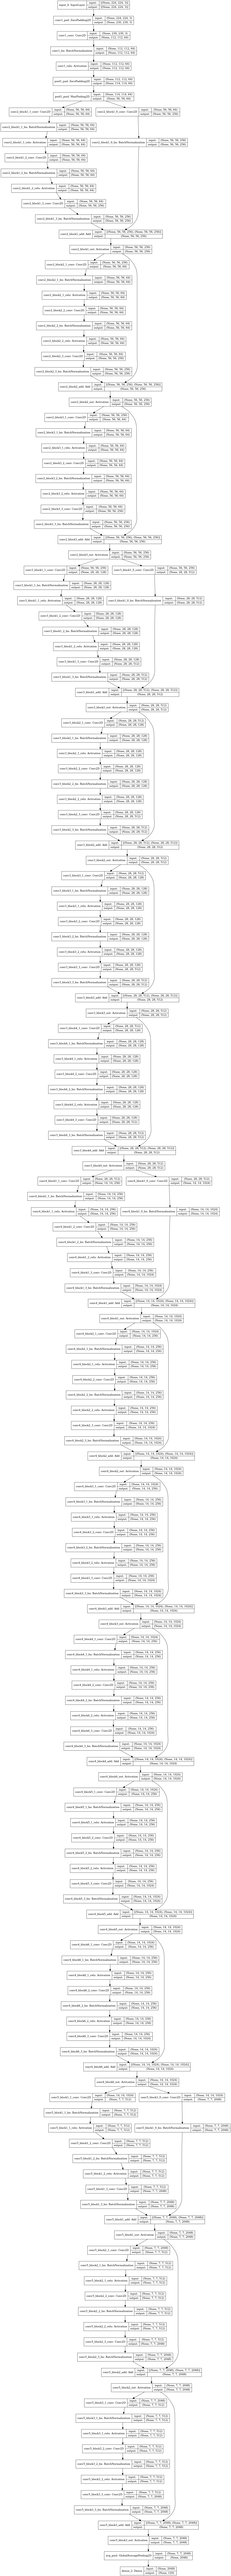

In [53]:
tf.keras.utils.plot_model(cam_model, show_shapes=True)

In [56]:
cam_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
    metrics = ['accuracy']
)

In [55]:
checkpoint_path = './cam.h5'

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_best_only = True,
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'max',
    verbose = 1
)

In [57]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
    callbacks =[checkpoint]
)

Epoch 1/10
750/750 [==============================] - 166s 212ms/step - loss: 2.1732 - accuracy: 0.4469 - val_loss: 3.4973 - val_accuracy: 0.1820

Epoch 00001: val_accuracy improved from -inf to 0.18204, saving model to ./cam.h5
Epoch 2/10
750/750 [==============================] - 162s 216ms/step - loss: 0.7683 - accuracy: 0.7812 - val_loss: 1.1621 - val_accuracy: 0.6600

Epoch 00002: val_accuracy improved from 0.18204 to 0.65998, saving model to ./cam.h5
Epoch 3/10
750/750 [==============================] - 162s 215ms/step - loss: 0.2789 - accuracy: 0.9357 - val_loss: 0.9743 - val_accuracy: 0.7176

Epoch 00003: val_accuracy improved from 0.65998 to 0.71758, saving model to ./cam.h5
Epoch 4/10
750/750 [==============================] - 160s 214ms/step - loss: 0.0802 - accuracy: 0.9903 - val_loss: 0.9262 - val_accuracy: 0.7354

Epoch 00004: val_accuracy improved from 0.71758 to 0.73540, saving model to ./cam.h5
Epoch 5/10
750/750 [==============================] - 159s 212ms/step - los

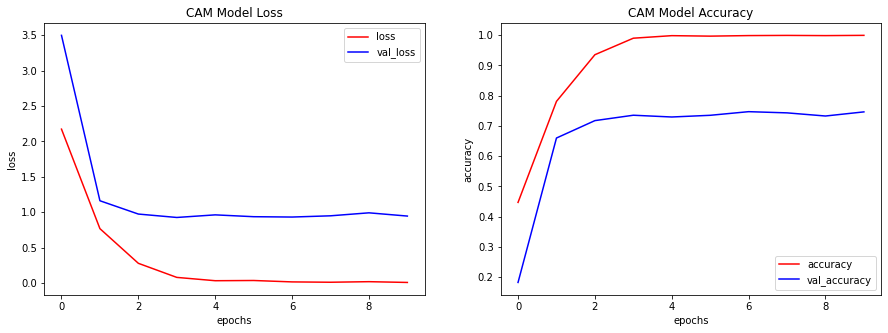

In [61]:
plt.subplots(figsize =(15,5))

plt.subplot(121)
plt.plot(history_cam_model.history['loss'],'r')
plt.plot(history_cam_model.history['val_loss'],'b')
plt.title('CAM Model Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])

plt.subplot(122)
plt.plot(history_cam_model.history['accuracy'],'r')
plt.plot(history_cam_model.history['val_accuracy'],'b')
plt.title('CAM Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])

# MAP

---
---
### 실험


In [36]:
print(ds_test)
print(ds_test.take(1))

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [25]:
ds = ds_test.take(1)
print(list(ds.as_numpy_iterator()))
print('\n\n')
print(list(ds.as_numpy_iterator())[0])

[(array([[[ 86, 116,  78],
        [ 86, 116,  78],
        [ 86, 116,  78],
        ...,
        [ 31,  47,  11],
        [ 35,  50,  19],
        [ 45,  60,  29]],

       [[ 86, 116,  78],
        [ 85, 115,  77],
        [ 85, 115,  77],
        ...,
        [ 42,  58,  22],
        [ 46,  61,  28],
        [ 53,  68,  37]],

       [[ 84, 116,  77],
        [ 84, 116,  77],
        [ 84, 116,  77],
        ...,
        [ 57,  74,  38],
        [ 57,  74,  40],
        [ 63,  80,  46]],

       ...,

       [[ 80,  79,  75],
        [117, 116, 112],
        [151, 150, 145],
        ...,
        [204, 195, 162],
        [187, 178, 145],
        [186, 177, 144]],

       [[135, 131, 128],
        [140, 136, 133],
        [151, 148, 143],
        ...,
        [159, 150, 121],
        [129, 120,  91],
        [130, 121,  92]],

       [[154, 150, 147],
        [136, 132, 129],
        [139, 136, 131],
        ...,
        [104,  94,  67],
        [ 84,  74,  47],
        [ 97,  87,  60

In [50]:
image, label = list(ds.as_numpy_iterator())[0]
print(image)
print(label)
print(image.shape)

[[[ 55  70 113]
  [ 59  74 115]
  [ 41  56  95]
  ...
  [ 27  29  15]
  [ 48  50  36]
  [ 41  44  27]]

 [[ 35  50  93]
  [ 42  57  98]
  [ 29  44  83]
  ...
  [ 43  47  32]
  [ 50  53  36]
  [ 32  36  19]]

 [[ 25  40  83]
  [ 34  49  90]
  [ 25  40  79]
  ...
  [ 10  17   1]
  [ 12  16   0]
  [  6  13   0]]

 ...

 [[123 152  86]
  [149 178 112]
  [136 162  97]
  ...
  [162 178 131]
  [188 201 155]
  [166 179 133]]

 [[102 131  65]
  [ 93 122  56]
  [137 164  97]
  ...
  [167 186 131]
  [155 172 118]
  [152 169 115]]

 [[138 167 101]
  [147 176 110]
  [118 145  78]
  ...
  [161 182 123]
  [133 151  93]
  [159 177 119]]]
84
(240, 320, 3)


In [53]:
if 'objects' in image :
    print("1")
else :
    print("0")

0


/tmp/ipykernel_5872/188662686.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'objects' in image :


In [26]:
sample_data = list(ds.as_numpy_iterator())[0]

In [131]:
if 'objects' in sample_data:
    print("1")
else:
    print("0")

0


/tmp/ipykernel_5872/1374596014.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'objects' in sample_data:


In [132]:
if isinstance(sample_data, dict) and 'objects' in sample_data:
    print("1")
else:
    print("0")

0


흠,,,, 뭐지?

object는 어디로 떠났지?

In [7]:
# as_supervised = False 
(ds_train_false, ds_test_false), ds_info_false = tfds.load(
    'stanford_dogs',
    split =['train', 'test'], 
    shuffle_files =True, 
    as_supervised = False,
    with_info = True
)

In [11]:
print(ds_test_false)
print('\n\n\n')
print(ds_test_false.take(1))


<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), label: (), objects: {bbox: (None, 4)}}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64, objects: {bbox: tf.float32}}>




<TakeDataset shapes: {image: (None, None, 3), image/filename: (), label: (), objects: {bbox: (None, 4)}}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64, objects: {bbox: tf.float32}}>


In [15]:
ds_false = ds_test_false.take(1)
sample_data_false = list(ds_false.as_numpy_iterator())
print(sample_data_false)

[{'image': array([[[ 86, 116,  78],
        [ 86, 116,  78],
        [ 86, 116,  78],
        ...,
        [ 31,  47,  11],
        [ 35,  50,  19],
        [ 45,  60,  29]],

       [[ 86, 116,  78],
        [ 85, 115,  77],
        [ 85, 115,  77],
        ...,
        [ 42,  58,  22],
        [ 46,  61,  28],
        [ 53,  68,  37]],

       [[ 84, 116,  77],
        [ 84, 116,  77],
        [ 84, 116,  77],
        ...,
        [ 57,  74,  38],
        [ 57,  74,  40],
        [ 63,  80,  46]],

       ...,

       [[ 80,  79,  75],
        [117, 116, 112],
        [151, 150, 145],
        ...,
        [204, 195, 162],
        [187, 178, 145],
        [186, 177, 144]],

       [[135, 131, 128],
        [140, 136, 133],
        [151, 148, 143],
        ...,
        [159, 150, 121],
        [129, 120,  91],
        [130, 121,  92]],

       [[154, 150, 147],
        [136, 132, 129],
        [139, 136, 131],
        ...,
        [104,  94,  67],
        [ 84,  74,  47],
        [ 97,

In [19]:
print(ds_train)
print(ds_test)
print(ds_train_false)
print(ds_test_false)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), label: (), objects: {bbox: (None, 4)}}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64, objects: {bbox: tf.float32}}>
<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), label: (), objects: {bbox: (None, 4)}}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64, objects: {bbox: tf.float32}}>


as_supervised = False 이면 다양한 정보가 들어 온다?

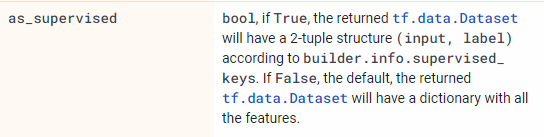

이래서 false로 만들어야 했네

In [37]:
print(sample_data)
print(sample_data_false[0])

(array([[[ 7,  3,  0],
        [ 7,  3,  0],
        [ 9,  2,  0],
        ...,
        [ 7,  6,  2],
        [ 7,  6,  2],
        [ 7,  6,  2]],

       [[23, 19, 10],
        [23, 19, 10],
        [25, 18, 10],
        ...,
        [ 8,  7,  3],
        [ 8,  7,  3],
        [ 8,  7,  3]],

       [[27, 23, 14],
        [27, 23, 14],
        [30, 23, 15],
        ...,
        [ 9,  8,  4],
        [ 9,  8,  4],
        [ 9,  8,  4]],

       ...,

       [[71, 75, 48],
        [54, 58, 31],
        [40, 45, 22],
        ...,
        [17, 23, 11],
        [16, 22, 10],
        [12, 18,  6]],

       [[71, 75, 48],
        [31, 35,  8],
        [17, 22,  0],
        ...,
        [19, 25, 13],
        [17, 23, 11],
        [16, 22, 10]],

       [[76, 80, 53],
        [27, 31,  4],
        [16, 21,  0],
        ...,
        [17, 23, 11],
        [14, 20,  8],
        [16, 22, 10]]], dtype=uint8), 71)
{'image': array([[[ 86, 116,  78],
        [ 86, 116,  78],
        [ 86, 116,  78],
 

In [39]:
sample_data_false[0]['objects']

{'bbox': array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)}

/tmp/ipykernel_31/24082059.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'objects' in sample_data:


75


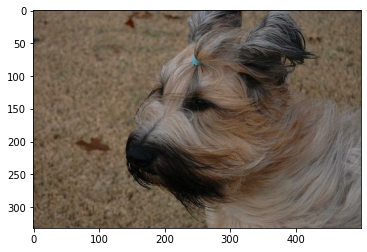

In [42]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

46


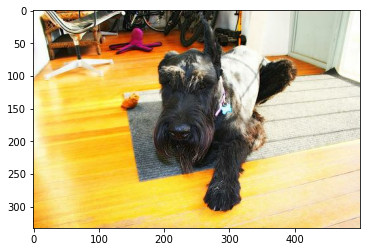

In [159]:
item_false = get_one(ds_test_false)
print(item_false['label'])
plt.imshow(item_false['image'])
plt.show()

80


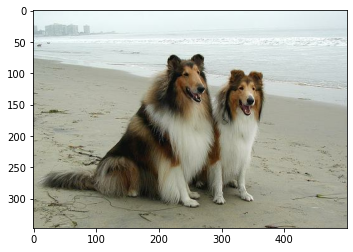

In [152]:
print(item_false['label'])
plt.imshow(item_false['image'])
plt.show()

---
---

In [53]:
# as_supervised = True 로 받아서 tuple로 들어 온 듯

def get_one_test(ds):  
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())[0]
    if isinstance(sample_data, tuple):
        image, label = sample_data
        return {'image': image, 'label': label}
    else:  # assuming it's a dictionary
        return sample_data

80


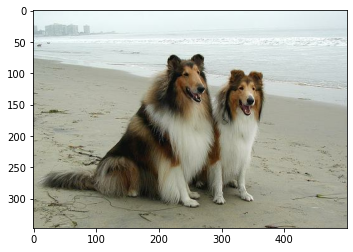

In [290]:
item = get_one_test(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [212]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    
    if 'objects' in sample_data[0]:
        # Handling the case when loaded with object detection information
        bbox = sample_data[0]['objects']['bbox']
        image = sample_data[0]['image']
        label = sample_data[0]['label']
        return sample_data[0]
    else:
        # Handling the case when loaded as supervised
        image, label = sample_data[0]
        return {'image': image, 'label': label}

/tmp/ipykernel_31/2551308429.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'objects' in sample_data[0]:


80


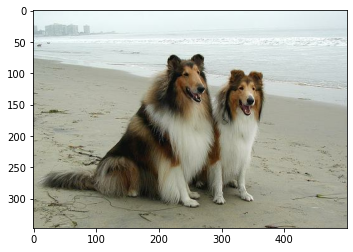

In [214]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [96]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item['image'], item['label'])
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]  # 마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [97]:
cam_model_path = './cam.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

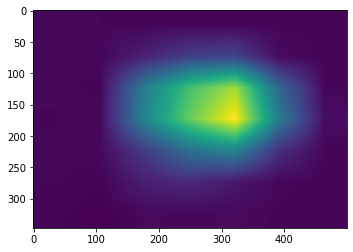

In [98]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

* CAM 이미지와 원본 이미지 합치는 함수
    
    * 기존 lms 코드는 visualize_cam_on_image(src1, src2, alpha=0.5) 라는 함수를 사용했지만 사실상 cv2.addWeighted() 함수가 핵심이라서 굳이 저 함수를 사용하지 않고 내게 필요한 함수인 get_cam_image_3channel() 로 바꿔서 사용하기로 결정
    
    * 기존 lms 코드 그대로 cv2.addWeighted() 를 진행하면 cam_image 픽셀 값이 음수일 경우 얼룩진 것처럼 블렌딩되는 문제 발생 => 해결하기 위해 픽셀 값을 ReLU 처리(음수를 0으로 만듦) 했고 완전한 0~255 컬러 표현을 가능하게 만들었음 => 부드럽게 블렌딩됨!
    
    * alpha 값을 0.5 가 아니라 0.7 로 변경함 => 뽑아낸 CAM 이미지와 원본 이미지를 합성했을 때 CAM 이미지가 더 두드러지게 나타나도록 하기 위함

In [99]:
def get_cam_image_3channel(item, cam_image, alpha=0.7):
    origin_image = item['image'].astype(np.uint8)

    # - 문제: cam_image 픽셀 값이 음수일 경우 255 를 곱해봤자 음수가 되므로 cv2.addWeighted() 가 제대로 진행되지 않는다. => 음수인 부분만 얼룩진 것처럼 됨
    # - 해결: ReLU 처리(음수를 0으로 만듦)를 통해 완전한 0~255 컬러 표현이 가능해짐 => cv2.addWeighted() 를 했을 때 부드럽게 블렌딩됨!
    cam_image_3channel = np.stack(np.maximum([cam_image*255]*3,0), axis=-1).astype(np.uint8)

    # 기존 lms 코드에 있던 visualize_cam_on_image(src1, src2, alpha=0.5)과 동일한 기능
    blended_image = cv2.addWeighted(cam_image_3channel, alpha, origin_image, 1.0-alpha, 0.0)
    return blended_image

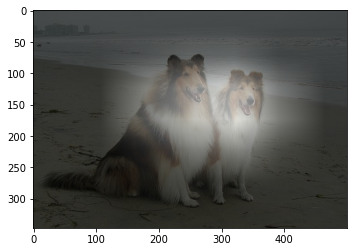

In [100]:
cam_blended_image = get_cam_image_3channel(item, cam_image)

plt.imshow(cam_blended_image)
plt.show()

# grad-CAM

In [101]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item['image'], item['label'])
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

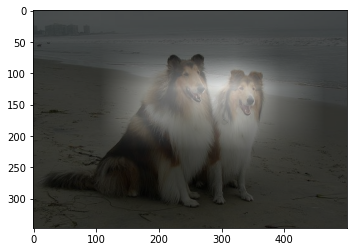

In [102]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
grad_cam_blended_image = get_cam_image_3channel(item, grad_cam_image)
plt.imshow(grad_cam_blended_image)
plt.show()

In [103]:
# CAM model 모든 레이어
CONV_NAMES = [
    'conv2_block1_out',
    'conv2_block2_out',
    'conv2_block3_out',
    'conv3_block1_out',
    'conv3_block2_out',
    'conv3_block3_out',
    'conv3_block4_out',
    'conv4_block1_out',
    'conv4_block2_out',
    'conv4_block3_out',
    'conv4_block4_out',
    'conv4_block5_out',
    'conv4_block6_out',
    'conv5_block1_out',
    'conv5_block2_out',
    'conv5_block3_out',
]

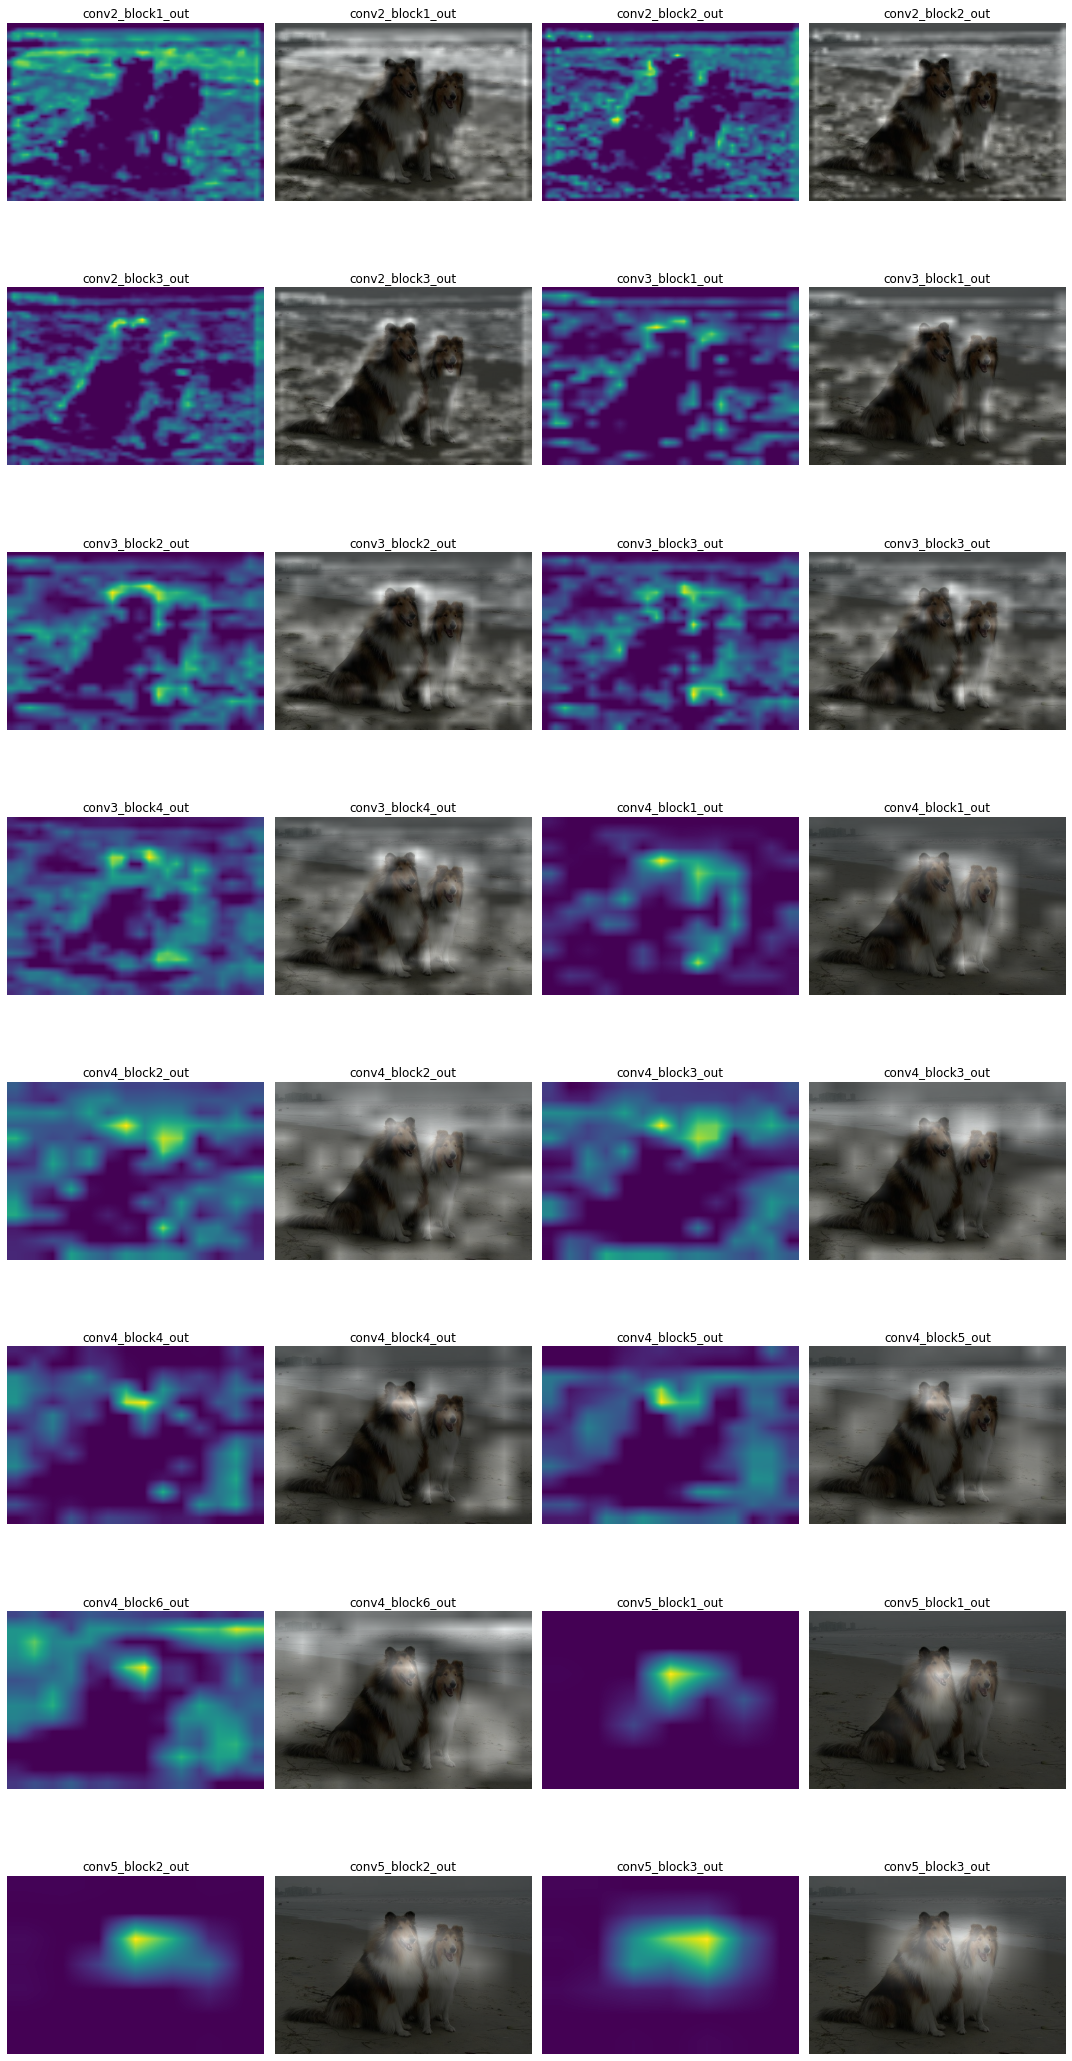

In [258]:
grad_cam_images = []
grad_cam_blended_images =[]

len_names = len(CONV_NAMES)
col = 4
row = 2 * len_names // col
cnt = 1

plt.subplots(figsize=(15,30))
for i in range(len_names) :
    grad_cam_image = generate_grad_cam(cam_model, CONV_NAMES[i], item)
    grad_cam_blended_image = get_cam_image_3channel(item, grad_cam_image)

    grad_cam_images.append(grad_cam_image)
    grad_cam_blended_images.append(grad_cam_blended_image)
    
    
    plt.subplot(row,col,cnt)
    plt.axis('off')
    plt.title(CONV_NAMES[i])
    plt.imshow(grad_cam_image)

    plt.subplot(row,col,cnt+1)
    plt.axis('off')
    plt.title(CONV_NAMES[i])
    plt.imshow(grad_cam_blended_image)
    
    cnt +=2
    
plt.tight_layout()
plt.show()

# bounding box

In [256]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

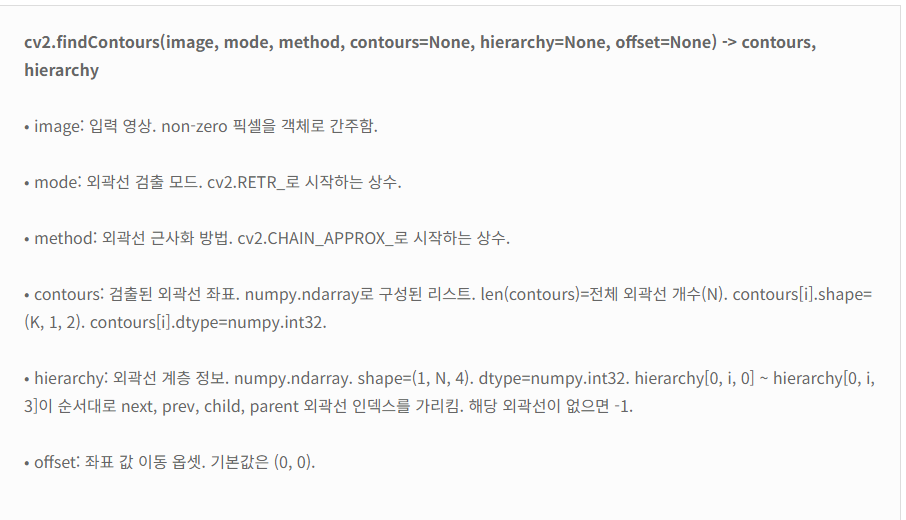

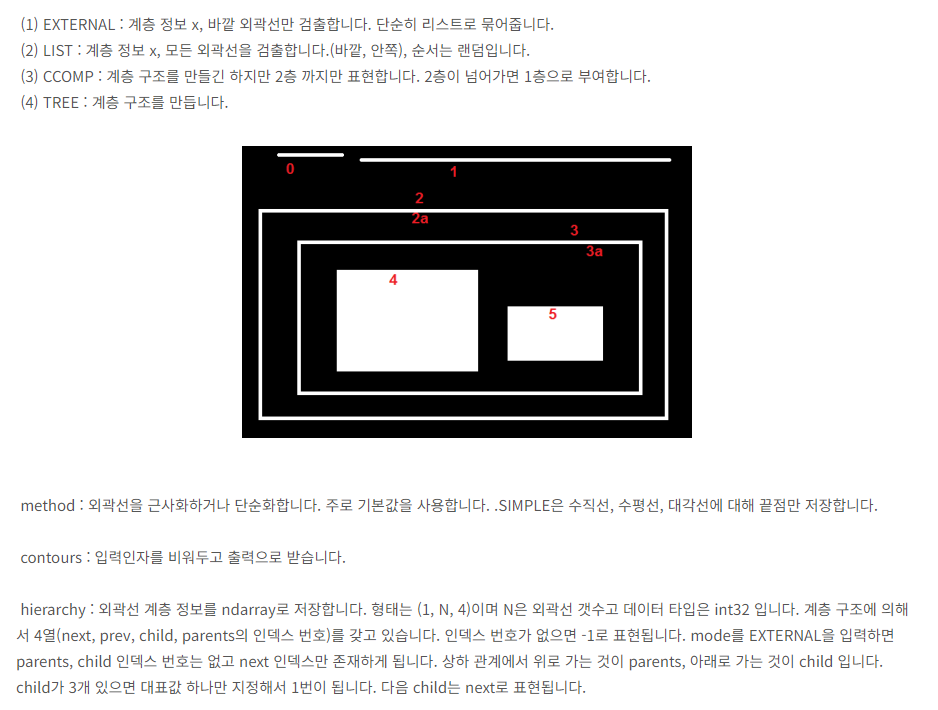

https://deep-learning-study.tistory.com/231

In [279]:
def get_bbox1(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

### cam

In [253]:
rect = get_bbox(cam_image)
rect

array([[ 91,  68],
       [427,   1],
       [478, 253],
       [141, 320]])

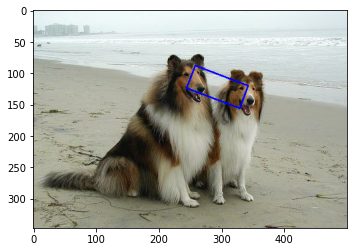

In [280]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

[[ 91  68]
 [427   1]
 [478 253]
 [141 320]]


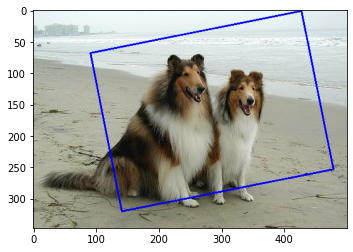

In [278]:
rect1 = get_bbox1(cam_image)
print(rect1)

image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect1], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### grad cam

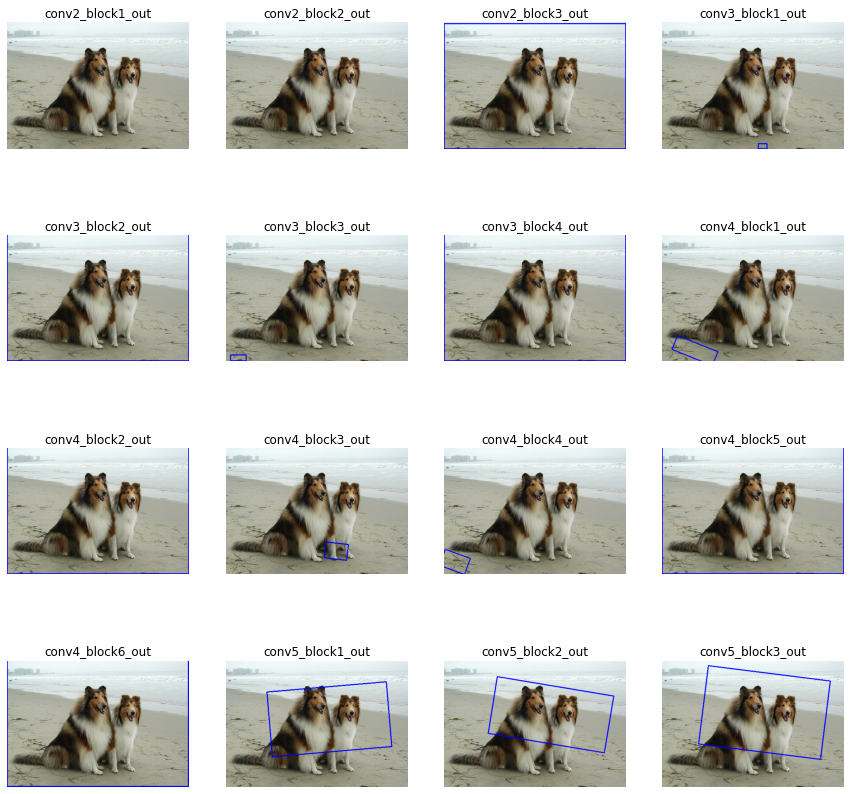

In [259]:
grad_cam_rects =[]

len_names = len(CONV_NAMES)
col = 4
row = len_names // col

plt.subplots(figsize = (15,15))

for i, (grad_cam_image, conv_name) in enumerate(zip(grad_cam_images, CONV_NAMES)) :
    rect = get_bbox(grad_cam_image)
    grad_cam_rects.append(rect)
    
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
    
    plt.subplot(row,col,i+1)
    plt.axis('off')
    plt.title(conv_name)
    plt.imshow(image)
    
plt.tight_layout
plt.show()

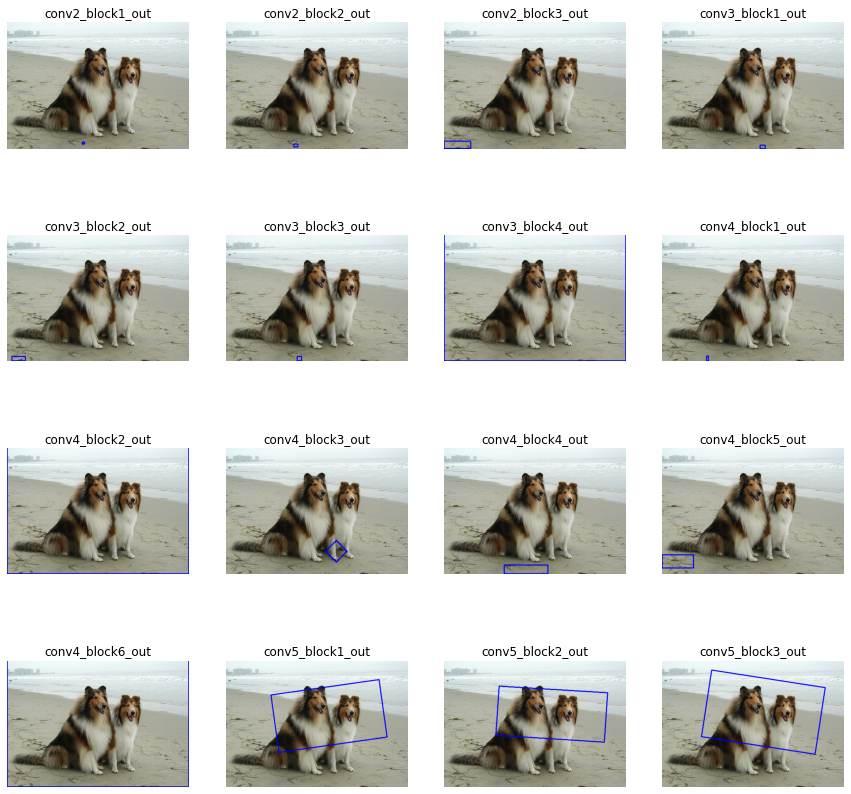

In [260]:
grad_cam_rects_01 =[]

len_names = len(CONV_NAMES)
col = 4
row = len_names // col

plt.subplots(figsize = (15,15))

for i, (grad_cam_image, conv_name) in enumerate(zip(grad_cam_images, CONV_NAMES)) :
    rect = get_bbox(grad_cam_image,score_thresh=0.1)
    grad_cam_rects_01.append(rect)
    
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
    
    plt.subplot(row,col,i+1)
    plt.axis('off')
    plt.title(conv_name)
    plt.imshow(image)
    
plt.tight_layout
plt.show()

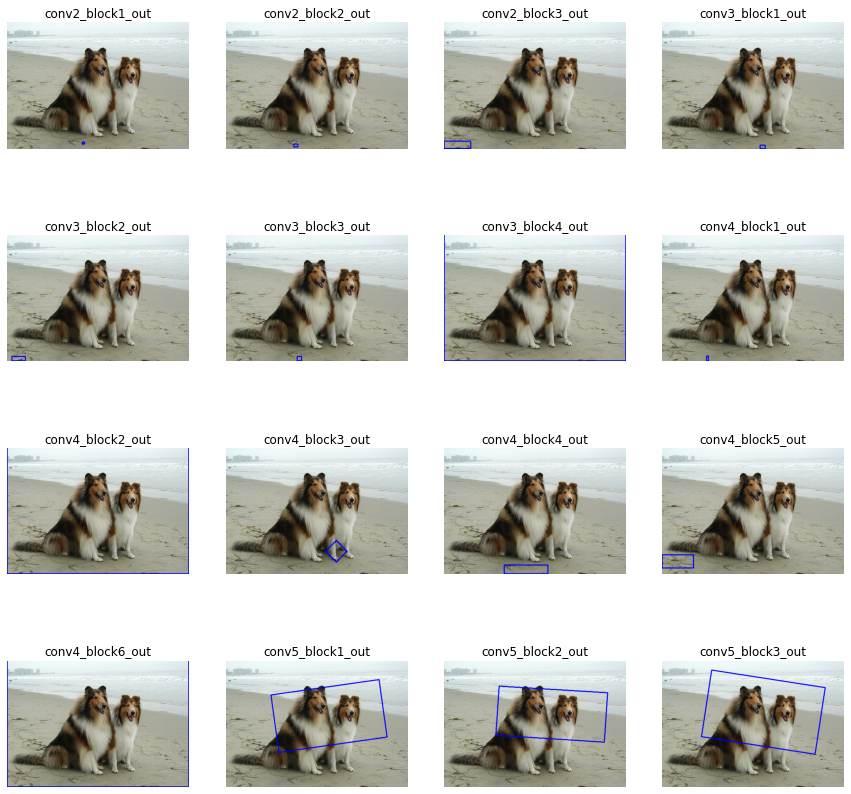

In [261]:
grad_cam_rects_001 =[]

len_names = len(CONV_NAMES)
col = 4
row = len_names // col

plt.subplots(figsize = (15,15))

for i, (grad_cam_image, conv_name) in enumerate(zip(grad_cam_images, CONV_NAMES)) :
    rect = get_bbox(grad_cam_image,score_thresh=0.01)
    grad_cam_rects_001.append(rect)
    
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
    
    plt.subplot(row,col,i+1)
    plt.axis('off')
    plt.title(conv_name)
    plt.imshow(image)
    
plt.tight_layout
plt.show()

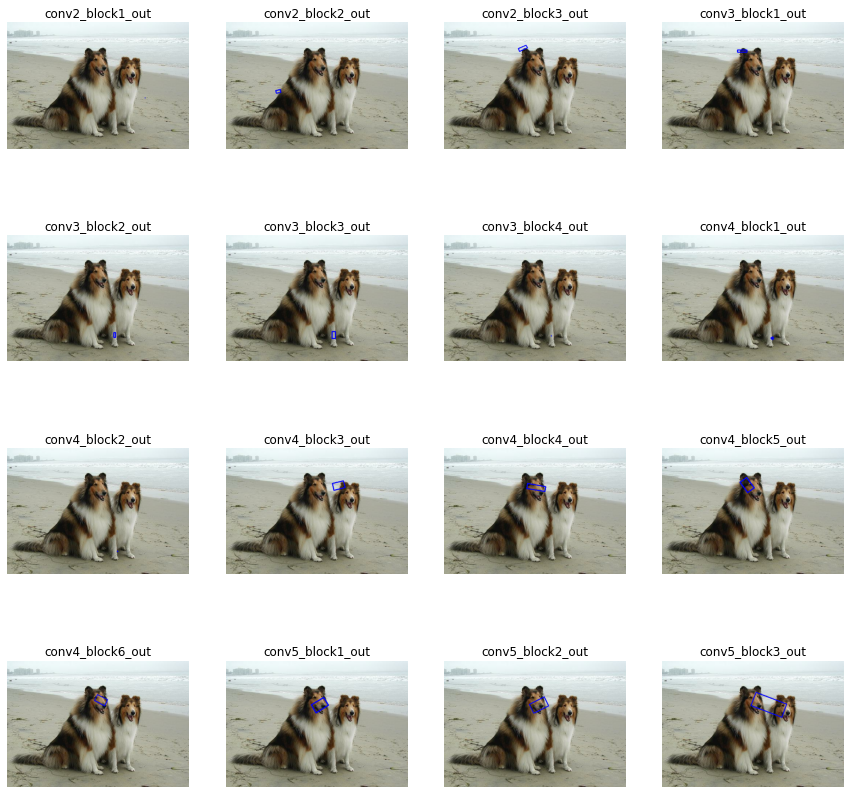

In [264]:
grad_cam_rects_08 =[]

len_names = len(CONV_NAMES)
col = 4
row = len_names // col

plt.subplots(figsize = (15,15))

for i, (grad_cam_image, conv_name) in enumerate(zip(grad_cam_images, CONV_NAMES)) :
    rect = get_bbox(grad_cam_image,score_thresh=0.8)
    grad_cam_rects_08.append(rect)
    
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
    
    plt.subplot(row,col,i+1)
    plt.axis('off')
    plt.title(conv_name)
    plt.imshow(image)
    
plt.tight_layout
plt.show()

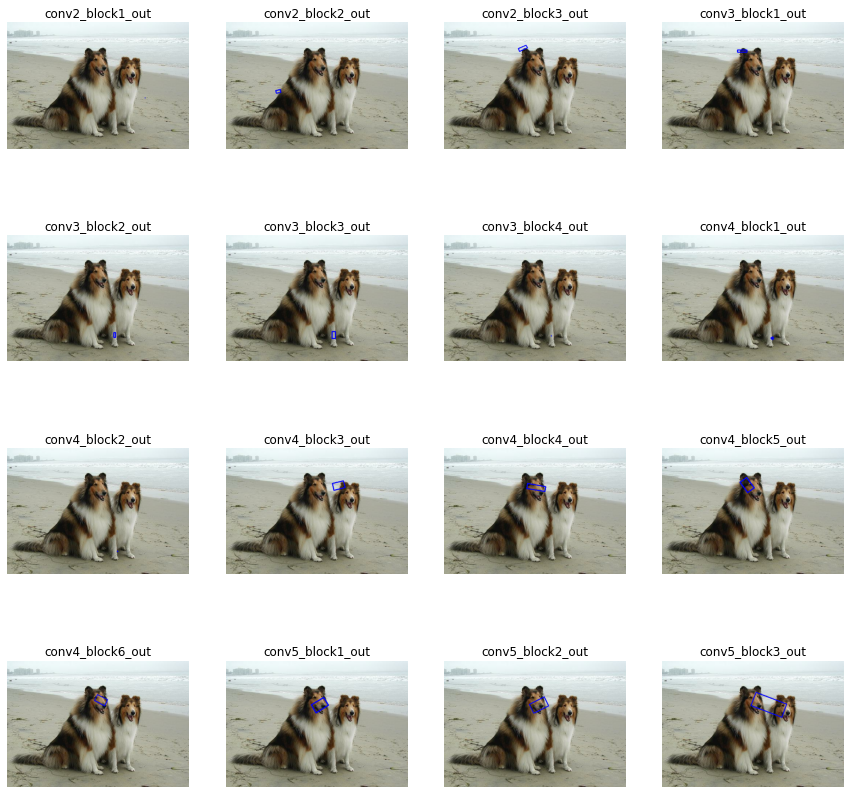

In [265]:
grad_cam_rects_001 =[]

len_names = len(CONV_NAMES)
col = 4
row = len_names // col

plt.subplots(figsize = (15,15))

for i, (grad_cam_image, conv_name) in enumerate(zip(grad_cam_images, CONV_NAMES)) :
    rect = get_bbox(grad_cam_image,score_thresh=0.001)
    grad_cam_rects_001.append(rect)
    
    image = copy.deepcopy(item['image'])
    image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
    
    plt.subplot(row,col,i+1)
    plt.axis('off')
    plt.title(conv_name)
    plt.imshow(image)
    
plt.tight_layout
plt.show()

# IOU

In [109]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  # bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  # bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]),  # bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]),  # bounding box의 x_max
    ]
    return bbox

In [166]:
# pred_bbox: predict 바운딩 박스
# truth_bbox: ground truth 바운딩 박스

def get_iou(pred_bbox, truth_bbox):
    y_min = max(pred_bbox[0], truth_bbox[0])
    x_min= max(pred_bbox[1], truth_bbox[1])
    y_max = min(pred_bbox[2], truth_bbox[2])
    x_max = min(pred_bbox[3], truth_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    pred_bboxArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    truth_bboxArea = (truth_bbox[2] - truth_bbox[0]) * (truth_bbox[3] - truth_bbox[1])
    iou = interArea / float(pred_bboxArea + truth_bboxArea - interArea)

    return iou

### cam

80


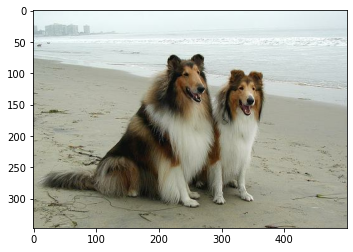

In [223]:
item_bbox= get_one(ds_test_false)
print(item_bbox['label'])
plt.imshow(item_bbox['image'])
plt.show()

In [225]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.043227665706051875, 0.2, 0.7809798270893372, 0.924]

In [226]:
item_bbox['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [227]:
cam_iou = get_iou(pred_bbox, item_bbox['objects']['bbox'][0])
print(f'cam 의 IoU 계산결과 :{cam_iou}')

cam 의 IoU 계산결과 :0.31208159983408446


### grad_cam

In [228]:
grad_cam_iou_dict = {}
for i, (rect, conv_name) in enumerate(zip(grad_cam_rects, CONV_NAMES)):
    pred_bbox = rect_to_minmax(rect, item['image'])
    iou = get_iou(pred_bbox, item_bbox['objects']['bbox'][0])
    grad_cam_iou_dict[conv_name] = iou
    print(f'{conv_name}의 IoU 계산 결과: {grad_cam_iou_dict[conv_name]}')

conv2_block1_out의 IoU 계산 결과: 1.457003758757973e-05
conv2_block2_out의 IoU 계산 결과: 0.0
conv2_block3_out의 IoU 계산 결과: 0.4021727827588082
conv3_block1_out의 IoU 계산 결과: 0.0
conv3_block2_out의 IoU 계산 결과: 0.39752338642633633
conv3_block3_out의 IoU 계산 결과: 0.0
conv3_block4_out의 IoU 계산 결과: 0.39752338642633633
conv4_block1_out의 IoU 계산 결과: 0.06274223627887744
conv4_block2_out의 IoU 계산 결과: 0.39752338642633633
conv4_block3_out의 IoU 계산 결과: 0.013383300357690763
conv4_block4_out의 IoU 계산 결과: 0.03003043994192519
conv4_block5_out의 IoU 계산 결과: 0.39752338642633633
conv4_block6_out의 IoU 계산 결과: 0.39947618159625564
conv5_block1_out의 IoU 계산 결과: 0.3327546327648682
conv5_block2_out의 IoU 계산 결과: 0.28431856687112095
conv5_block3_out의 IoU 계산 결과: 0.31208159983408446


# 회고

as_supervised = True가 되면 image, label 값만 도출

as_supervised = False 가 되면 image, label, [objects][bbox], filename 도출
 
 -> 학습만 진행하면 true / 다른 정보 필요 false
 
 <br />

학습 진행시 overfitting 이 발생하면 bbox 크기가 어떻게 달라질까?
<br /><br />
conv block 이 진행됨에 따라 bbox 크기가 커졌다 작아졌다 반복
<br /><br />
grad cam은 더 특징점을 뽑아 내는 느낌

cam은 전체적으로 도출하는 느낌 


cv2.findContours(cam_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 얘는 차이가 안보임

score_thresh 규칙도 잘 안보임